In [11]:
# for file management
import os
import logging
from docopt import docopt

# For analysis
import numpy as np
from osgeo import gdal
import pandas as pd
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.svm import SVC
from scipy import stats
from itertools import product
from sklearn.metrics import cohen_kappa_score
# For visualization
% matplotlib inline
from matplotlib import pyplot as plt

UsageError: Line magic function `%` not found.


In [39]:
# you need to set the right directory on your own setting!!!
# Please set the diretory(path) of your raster_data, train_data, and test_data.

raster_data_path13 = "D:\\GEODATA\\Satellite\\2021-1(MEU_FINAL)\\MEU_FINAL\\L8_20130916\\L8_Seoul_20130916.tif"
raster_data_path20 = "D:\\GEODATA\\Satellite\\2021-1(MEU_FINAL)\\MEU_FINAL\\L8_20200428\\L8_Seoul_20200428.tif"
train_data_path = "D:\\GEODATA\\Satellite\\2021-1(MEU_FINAL)\\MEU_FINAL\\Data\\TRAIN-"
test_data_path = "D:\\GEODATA\\Satellite\\2021-1(MEU_FINAL)\\MEU_FINAL\\Data\\TEST-"

In [16]:
# Read raster from gdal
raster_dataset13 = gdal.Open(raster_data_path13, gdal.GA_ReadOnly)

# Get Projection system of your raster file
geo_transform = raster_dataset13.GetGeoTransform()
proj = raster_dataset13.GetProjectionRef()

# Read bands as arrays
bands_data13 = []
for b in range(1, raster_dataset13.RasterCount+1):
    band = raster_dataset13.GetRasterBand(b)
    bands_data13.append(band.ReadAsArray())

#Stack arrays together 
bands_data13 = np.dstack(bands_data13)

# Change NA values to zero
bands_data13[np.isnan(bands_data13)] = 0

# Get the shape of the image 
rows, cols, n_bands = bands_data13.shape

###################################################### do above codes again for different raster set
# Read raster
raster_dataset20 = gdal.Open(raster_data_path20, gdal.GA_ReadOnly)
# Get Projection system 
geo_transform = raster_dataset20.GetGeoTransform()
proj = raster_dataset20.GetProjectionRef()

# Read bands as arrays
bands_data20 = []
for b in range(1, raster_dataset20.RasterCount+1):
    band = raster_dataset20.GetRasterBand(b)
    bands_data20.append(band.ReadAsArray())

#Stack arrays together 
bands_data20 = np.dstack(bands_data20)

# Change NA values to zero
bands_data20[np.isnan(bands_data20)] = 0

# Get the shape of the image 
rows, cols, n_bands = bands_data20.shape

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(<AxesSubplot:title={'center':'2020'}>,
 Text(0.5, 1.0, '2020'))

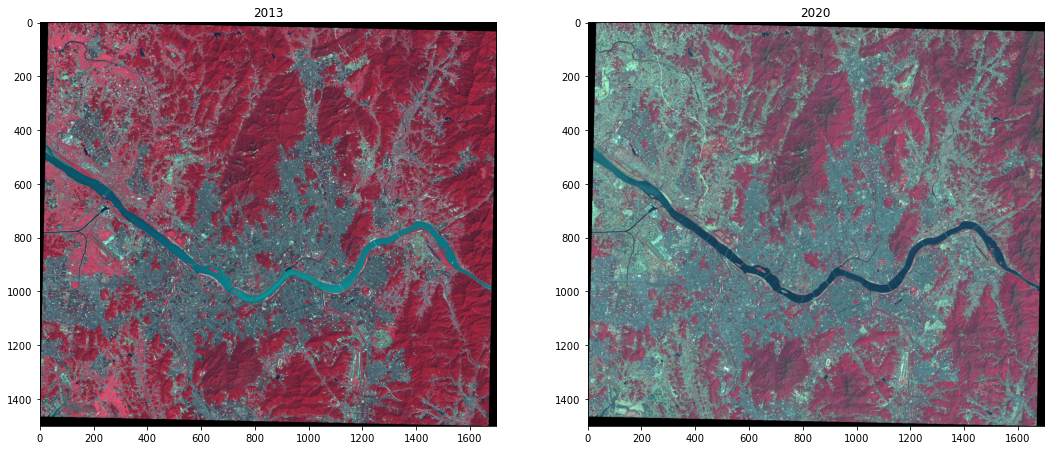

In [17]:
fig, ax = plt.subplots(1,4, figsize =(18,15))
###########################################

#####
# Select False color bands
b4_13 = bands_data13[:,:,3]
b3_13 = bands_data13[:,:,2]
b2_13 = bands_data13[:,:,1]

# Stack them
false_color13 = np.dstack([b4_13,b3_13*2,b2_13*2])

#####
# Select False color bands
b4_20 = bands_data20[:,:,3]
b3_20 = bands_data20[:,:,2]
b2_20 = bands_data20[:,:,1]

# Stack them
false_color20 = np.dstack([b4_20,b3_20*2,b2_20*2])

#Plot
#Plot
plt.subplot(121), plt.imshow(false_color13*2), plt.title("2013")
plt.subplot(122), plt.imshow(false_color20*2), plt.title("2020")

In [18]:
######## Normality Test #########


# Read image as array
img_arr13 = raster_dataset13.ReadAsArray()
img_arr20 = raster_dataset20.ReadAsArray()

# change the array type to float 32
img_arr13_f = img_arr13.astype(np.float32)
img_arr20_f = img_arr20.astype(np.float32)


# Flatten the array to a one dimension array
img13_flatten= img_arr13_f.flatten()
img20_flatten= img_arr20_f.flatten()


In [19]:
print("1XD Array of the 2013 image = %s" %img13_flatten.shape)
print("1XD Array of the 2020 image = %s" %img20_flatten.shape)

1XD Array of the 2013 image = 15282000
1XD Array of the 2020 image = 15282000


In [37]:
# Create mask
def create_mask_from_vector(vector_data_path, cols, rows, geo_transform,
                            projection, target_value=1):
    data_source = gdal.OpenEx(vector_data_path, gdal.OF_VECTOR)

    # Read each layer
    layer = data_source.GetLayer(0)

    # Get the data type
    driver = gdal.GetDriverByName('MEM')  # In memory dataset
    target_ds = driver.Create('', cols, rows, 1, gdal.GDT_UInt16)

    # Set the projection the same as the images
    target_ds.SetGeoTransform(geo_transform)
    target_ds.SetProjection(projection)

    # Rasterize mask
    gdal.RasterizeLayer(target_ds, [1], layer, burn_values=[target_value])
    return target_ds


# Rasterize vector
def vectors_to_raster(file_paths, rows, cols, geo_transform, projection):
    """Rasterize the vectors in the given directory in a single image."""
    labeled_pixels = np.zeros((rows, cols))

    # Create arrays of sample data
    for i, path in enumerate(file_paths):
        label = i+1
        ds = create_mask_from_vector(path, cols, rows, geo_transform,
                                     projection, target_value=label)
        band = ds.GetRasterBand(1)
        labeled_pixels += band.ReadAsArray()
        ds = None
    return labeled_pixels

In [40]:
# Get all the files ending with .shp
train_files = [f for f in os.listdir(train_data_path) if f.endswith('.shp')]

# Get the name of shapefiles and save it as classes
training_classes = [f.split('.')[0] for f in train_files]

#Join directory path with file names
train_shpfile = [os.path.join(train_data_path, f)
              for f in train_files if f.endswith('.shp')]

# Rasterize vectors
labeled_pixels = vectors_to_raster(train_shpfile, rows, cols, geo_transform, proj)

# Return non-zero values
is_train = np.nonzero(labeled_pixels)

#Get label and sample data
training_labels = labeled_pixels[is_train]
training_samples13 = bands_data13[is_train]
training_samples20 = bands_data20[is_train]

In [41]:
label_vals=[]
sample_vals=[]
for i in np.unique(training_labels):
    label_tot = sum(training_labels==i)
    sample_tot = (sum(training_labels==i))*10
    label_vals.append(label_tot)
    sample_vals.append(sample_tot)

stats_all= [sample_vals, label_vals]


stat_summary = pd.DataFrame(data =stats_all,
            index = ['Training samples','Label/target samples'],
            columns = ['Built Up', 'Farm', 'Forest', 'WATER'])


print("Total number of Training samples: %s points" %training_labels.size)
print("Total number of Label samples %s" %training_samples20.size)
print(" Across the three classes: ")
print("")
print(stat_summary)

Total number of Training samples: 886 points
Total number of Label samples 5316
 Across the three classes: 

                      Built Up  Farm  Forest  WATER
Training samples          2650  1570    2830   1810
Label/target samples       265   157     283    181


In [42]:
# It may takes minutes

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

rf = RandomForestClassifier(random_state=0)
param_grid = {'n_estimators': [10, 100, 200, 300, 400, 500], 'max_depth': [4,6,8,10,12], 'min_samples_leaf': [3,5,7,10],
             'min_samples_split': [2,3,5,10]}
classifier_13 = GridSearchCV(rf, param_grid=param_grid, scoring="accuracy", n_jobs= -1, verbose =1)
classifier_13.fit(training_samples13, training_labels)
print(classifier_13.best_params_)

Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   55.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  3.6min


{'max_depth': 12, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100}


[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:  4.7min finished


In [43]:
# It may takes minutes

param_grid = {'n_estimators': [10, 100, 200, 300, 400, 500], 'max_depth': [4,6,8,10,12], 'min_samples_leaf': [3,5,7,10],
             'min_samples_split': [2,3,5,10]}
classifier_20 = GridSearchCV(rf, param_grid=param_grid, scoring="accuracy", n_jobs= -1, verbose =1)
classifier_20.fit(training_samples20, training_labels)
print(classifier_20.best_params_)

Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 208 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done 458 tasks      | elapsed:   45.8s
[Parallel(n_jobs=-1)]: Done 808 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1258 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1808 tasks      | elapsed:  3.2min


{'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100}


[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:  4.2min finished


In [44]:
classifier13=RandomForestClassifier(max_depth=12, min_samples_leaf=3, min_samples_split=2, n_estimators=100 )
classifier_13=classifier13.fit(training_samples13, training_labels)
classifier_13

RandomForestClassifier(max_depth=12, min_samples_leaf=3)

In [45]:
classifier20=RandomForestClassifier(max_depth=10, min_samples_leaf=3, min_samples_split=2, n_estimators=100 )
classifier_20=classifier20.fit(training_samples20, training_labels)
classifier_20

RandomForestClassifier(max_depth=10, min_samples_leaf=3)

In [46]:
# Band importance for the 2013 image classifier

bands = [1, 2, 3, 4, 5, 6]
for b, imp in zip(bands, classifier_13.feature_importances_):
    print('Band {b} importance: {imp}'.format(b=b, imp=imp))

Band 1 importance: 0.16393326542989992
Band 2 importance: 0.13728113412597956
Band 3 importance: 0.08089825462565466
Band 4 importance: 0.2743696217821892
Band 5 importance: 0.15170493209413854
Band 6 importance: 0.19181279194213824


In [47]:
# Band importance for the 2020 image classifier

for b, imp in zip(bands, classifier_20.feature_importances_):
    print('Band {b} importance: {imp}'.format(b=b, imp=imp))

Band 1 importance: 0.2206592231273711
Band 2 importance: 0.11994667937322312
Band 3 importance: 0.10448594113510767
Band 4 importance: 0.2592379419403418
Band 5 importance: 0.16132998704956478
Band 6 importance: 0.13434022737439158


In [48]:
# Grab the dimension
n_samples = rows*cols

# Reshape images dimension
flat_pixels13 = bands_data13.reshape((n_samples, n_bands))
flat_pixels20 = bands_data20.reshape((n_samples, n_bands))

# Predict
result_13 = classifier_13.predict(flat_pixels13)
result_20 = classifier_20.predict(flat_pixels20)

# Get the rows and columns
classification_2013 = result_13.reshape((rows, cols))
classification_2020 = result_20.reshape((rows, cols))

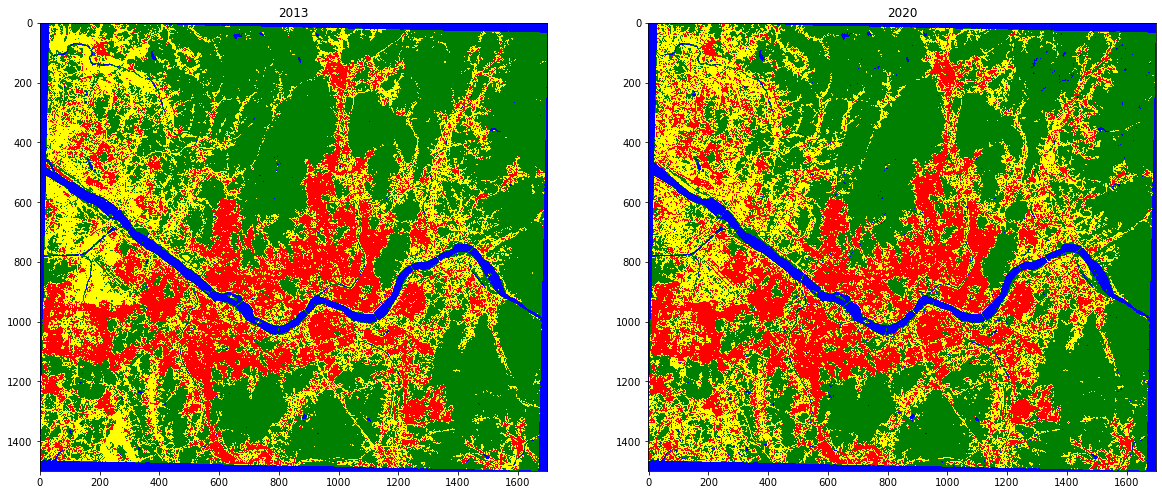

In [49]:
# Get the calssification visualization
# it may takes a minute

fig, ax = plt.subplots(1,2, figsize =(20,16))

colors = ['red', 'yellow', 'green', 'blue']
cmap = matplotlib.colors.ListedColormap(colors)
plt.subplot(121), plt.imshow(classification_2013, cmap = cmap),plt.title("2013")
plt.subplot(122), plt.imshow(classification_2020, cmap = cmap),plt.title("2020")
plt.show()

In [50]:
test_files  = [f for f in os.listdir(test_data_path) if f.endswith('.shp')]

# Get the name of shapefiles and save it as classes
testing_classes = [f.split('.')[0] for f in test_files]


# Get the test shapefile data
test_shpfile = [os.path.join(test_data_path, "%s.shp" % c)
              for c in testing_classes]

# Rasterize shapefiles
test_pixels = vectors_to_raster(test_shpfile, rows, cols,
                                        geo_transform, proj)

#Create non-zero images
test_image = np.nonzero(test_pixels)


#Get test outputs and labels
testing_labels = test_pixels[test_image]
predicted_labels13 = classification_2013[test_image]
predicted_labels20 = classification_2020[test_image]

In [51]:


label_vals=[]
sample_vals=[]
for i in np.unique(testing_labels):
    label_tot = sum(testing_labels==i)
    sample_tot = (sum(testing_labels==i))*1
    label_vals.append(label_tot)
    sample_vals.append(sample_tot)

stats_all= [sample_vals, label_vals]


stat_summary = pd.DataFrame(data =stats_all,
            index = ['Testing samples','Label/target samples'],
            columns = ['Built Up', 'Farm', 'Forest', 'WATER'])


print("Total number of Testing samples: %s points" %testing_labels.size)
print(" Across the four classes: ")
print("")
print(stat_summary)

Total number of Testing samples: 249 points
 Across the four classes: 

                      Built Up  Farm  Forest  WATER
Testing samples             55    52      65     77
Label/target samples        55    52      65     77


In [52]:
# Overall accuracy of classification result of 2013 satellite image.

target_names = ['Class %s' % s for s in testing_classes]
print("Classification report:\n%s" %
      metrics.classification_report(testing_labels, predicted_labels13,
                                    target_names=target_names))
print("Overall accuracy: %f" %
      metrics.accuracy_score(testing_labels, predicted_labels13))

print ("Kappa Statistics: %f " %
       cohen_kappa_score(testing_labels, predicted_labels13))

Classification report:
                   precision    recall  f1-score   support

    Class BU_TEST       0.88      0.91      0.89        55
  Class FARM_TEST       0.85      0.63      0.73        52
Class FOREST_TEST       0.81      0.92      0.86        65
 Class WATER_TEST       0.96      0.99      0.97        77

         accuracy                           0.88       249
        macro avg       0.87      0.86      0.86       249
     weighted avg       0.88      0.88      0.88       249

Overall accuracy: 0.879518
Kappa Statistics: 0.837414 


In [53]:
# Overall accuracy of classification result of 2020 satellite image.

target_names = ['Class %s' % s for s in testing_classes]
print("Classification report:\n%s" %
      metrics.classification_report(testing_labels, predicted_labels20,
                                    target_names=target_names))
print("Overall accuracy: %f" %
      metrics.accuracy_score(testing_labels, predicted_labels20))
print ("Kappa Statistics: %f " %
       cohen_kappa_score(testing_labels, predicted_labels20))

Classification report:
                   precision    recall  f1-score   support

    Class BU_TEST       0.82      0.89      0.85        55
  Class FARM_TEST       0.78      0.62      0.69        52
Class FOREST_TEST       0.83      0.91      0.87        65
 Class WATER_TEST       0.96      0.96      0.96        77

         accuracy                           0.86       249
        macro avg       0.85      0.84      0.84       249
     weighted avg       0.86      0.86      0.86       249

Overall accuracy: 0.859438
Kappa Statistics: 0.810646 


In [54]:
# Change each image to an integer array type
arr1 = np.array(classification_2013, dtype = int)
arr2 = np.array(classification_2020, dtype = int)

# Iterate to check for change
lookup = np.array(((0, 2, 3, 4),
                   (1, 0, 3, 4),
                   (1, 2, 0, 4),
                   (1, 2, 3, 0)), dtype=int)

detection_layer = np.zeros_like(arr1)

for r, c in product(*[range(x) for x in arr1.shape]):
    a, b = arr1[r,c], arr2[r,c]
    detection_layer[r,c] = lookup[a-1,b-1]

In [55]:
# Detecting Changes of land cover between 2013 and 2020

change_unique = np.unique(detection_layer)
class_change = []

# Count Pixels
for group in change_unique:
    class_change.append(len(detection_layer[detection_layer == group]))

# Change Pixels to Sq.Km
class_size = []
for i in class_change:
    area = i *0.001
    area_arr = np.array(area).round(2)
    class_size.append(area_arr)


print("%r pixels or %r Km.Sq area showed no change "  %(class_change[0], class_size[0]))
print("%r pixels %r Km.Sq changed to Builtup area" %(class_change[1],  class_size[1]))
print("%r pixels %r Km.Sq changed to Farm & Barren" %(class_change[2], class_size[2]))
print("%r pixels %r Km.Sq changed to Vegetation" %(class_change[3], class_size[3]))
print("%r pixels %r Km.Sq changed to Water & Wetland" %(class_change[4], class_size[4]))

1986867 pixels or 1986.87 Km.Sq area showed no change 
144485 pixels 144.49 Km.Sq changed to Builtup area
222878 pixels 222.88 Km.Sq changed to Farm & Barren
129439 pixels 129.44 Km.Sq changed to Vegetation
63331 pixels 63.33 Km.Sq changed to Water & Wetland


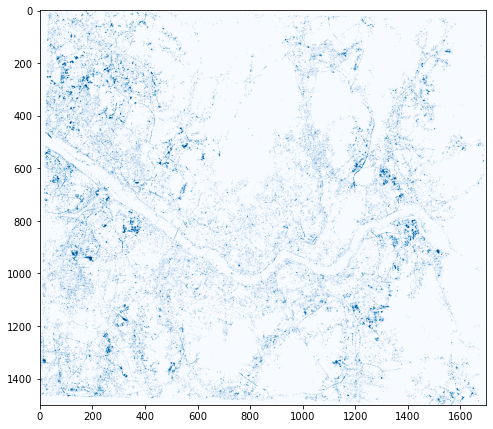

In [56]:
# Images of changed built-up area in 2020

fig = plt.subplots( figsize =(8,8))
plt.imshow(detection_layer==1, cmap="Blues" )
plt.show()